In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
%matplotlib inline

In [46]:
# Load dataset
df = pd.read_csv("/Users/sakshizanjad/Desktop/grocery_expiry_project/data/processed/intermediate_data.csv")

In [47]:
# Clean and convert Unit_Price to float
df['Unit_Price'] = df['Unit_Price'].replace(r'[\$,]', '', regex=True).astype(float)

# Convert date columns (as requested, without loop)
df['Date_Received'] = pd.to_datetime(df['Date_Received'], errors='coerce')
df['Last_Order_Date'] = pd.to_datetime(df['Last_Order_Date'], errors='coerce')
df['Expiration_Date'] = pd.to_datetime(df['Expiration_Date'], errors='coerce')

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2970 entries, 0 to 2969
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Product_ID                  2970 non-null   object        
 1   Product_Name                2970 non-null   object        
 2   Category                    2970 non-null   object        
 3   Supplier_ID                 2970 non-null   object        
 4   Supplier_Name               2970 non-null   object        
 5   Stock_Quantity              2970 non-null   int64         
 6   Reorder_Level               2970 non-null   int64         
 7   Reorder_Quantity            2970 non-null   int64         
 8   Unit_Price                  2970 non-null   float64       
 9   Date_Received               2970 non-null   datetime64[ns]
 10  Last_Order_Date             2970 non-null   datetime64[ns]
 11  Expiration_Date             2970 non-null   datetime64[n

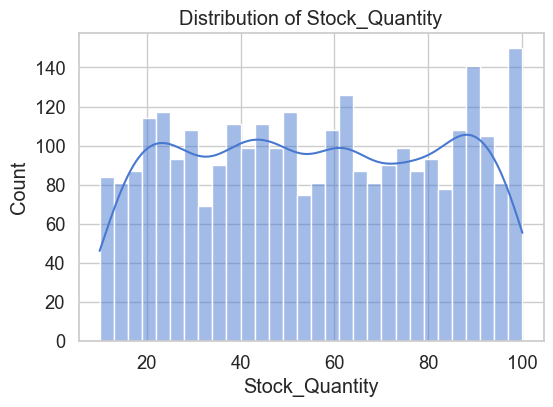

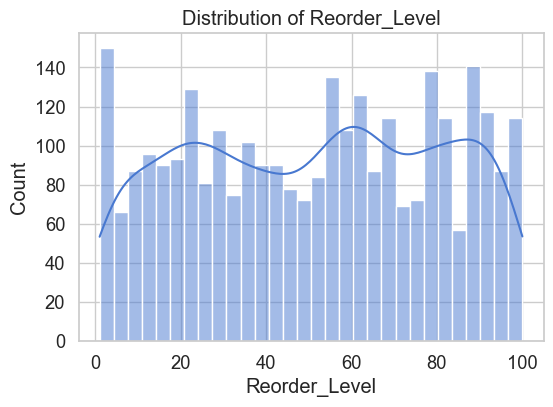

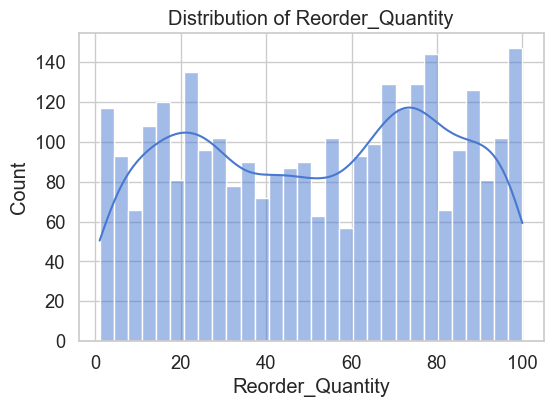

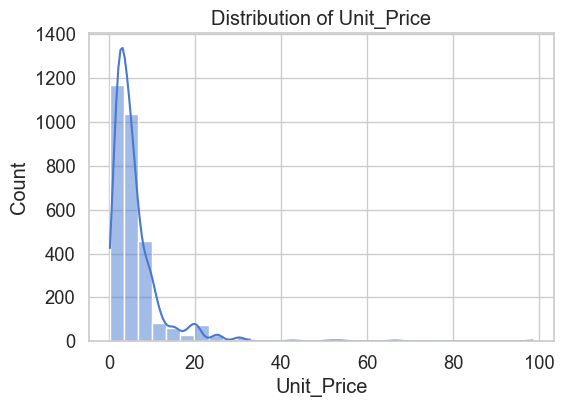

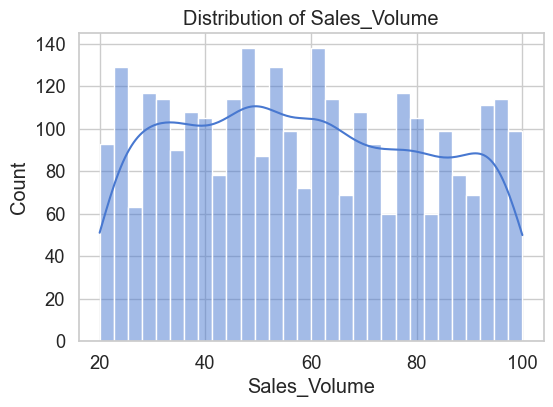

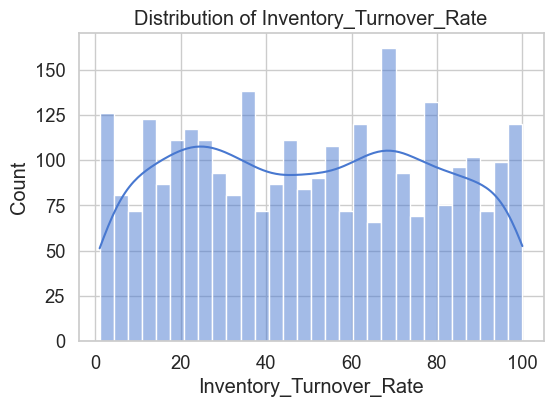

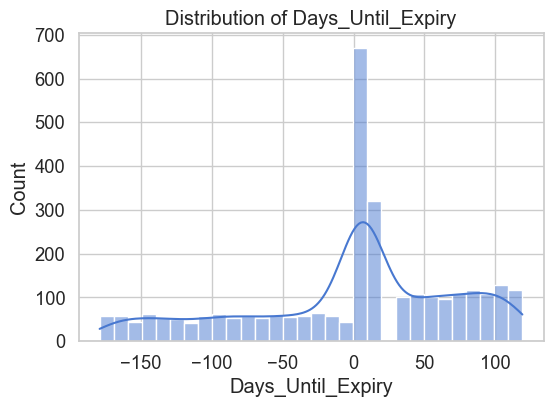

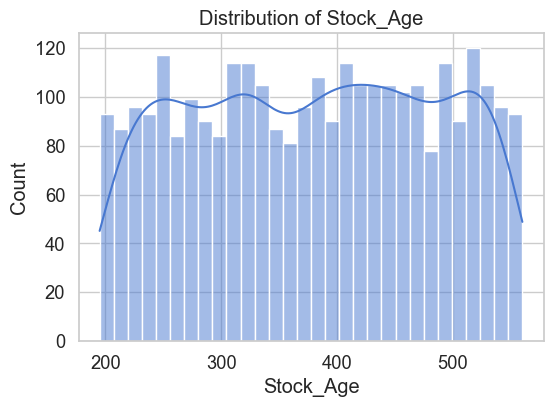

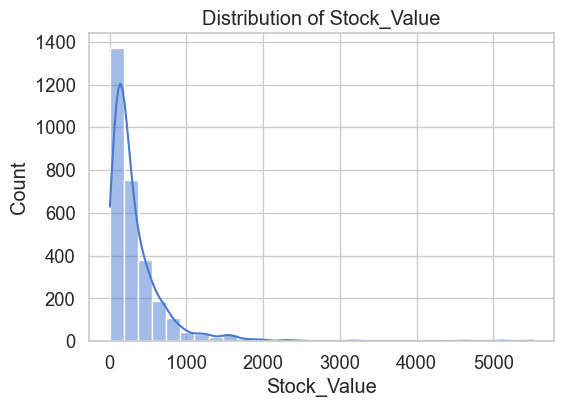

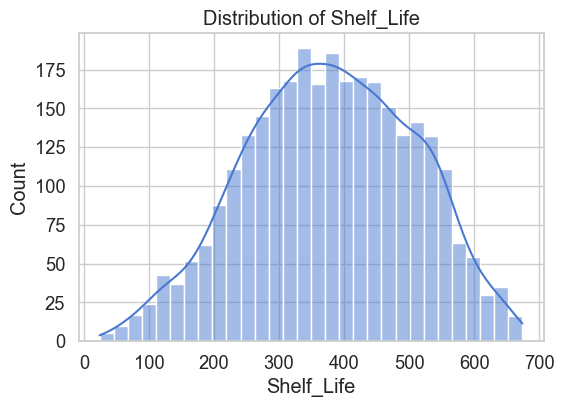

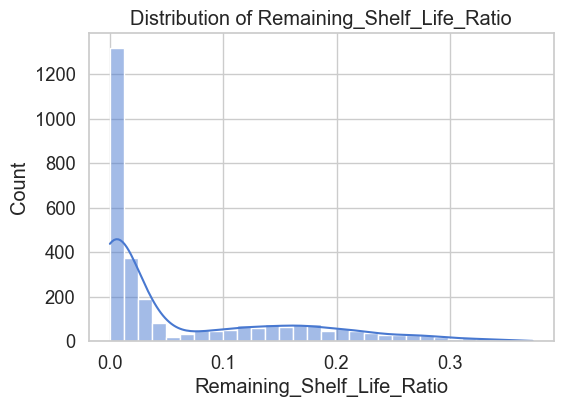

In [49]:
#Numerical feature distributions
num_cols = ['Stock_Quantity', 'Reorder_Level', 'Reorder_Quantity', 'Unit_Price', 'Sales_Volume',
            'Inventory_Turnover_Rate', 'Days_Until_Expiry', 'Stock_Age', 'Stock_Value', 'Shelf_Life', 'Remaining_Shelf_Life_Ratio']

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

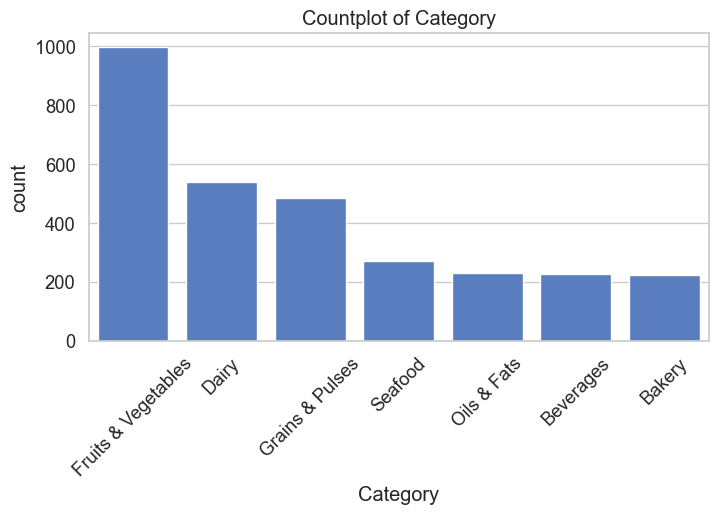

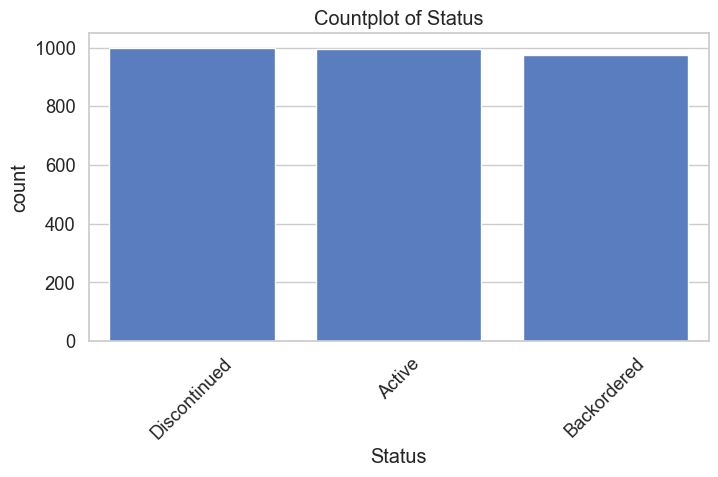

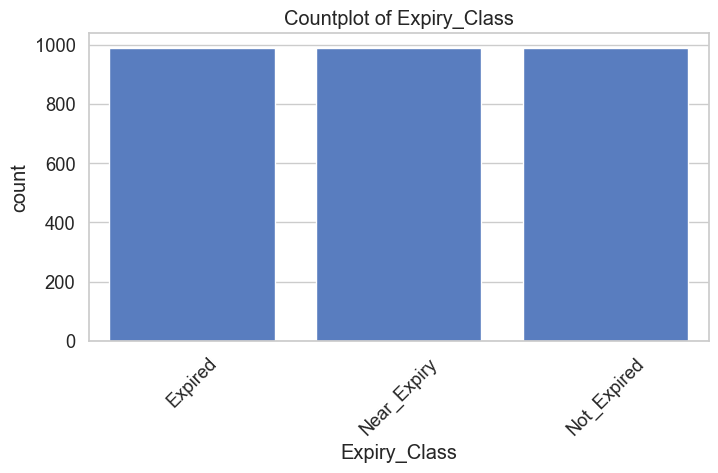

In [50]:
#Categorical feature distributions
cat_cols = ['Category', 'Status', 'Expiry_Class']

for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f'Countplot of {col}')
    plt.show()

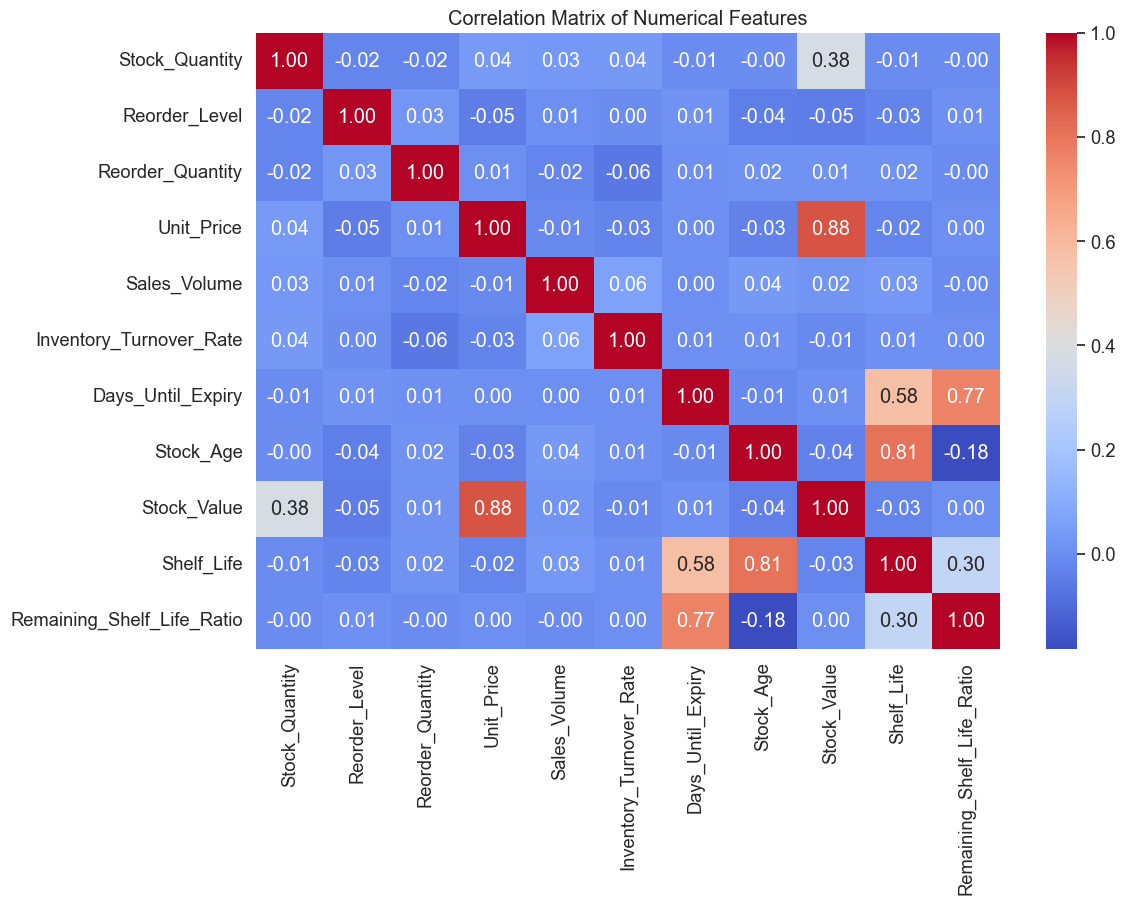

In [51]:
#Correlation analysis
plt.figure(figsize=(12,8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

Hypothesis Testing

In [52]:
#Chi-square test for Category vs Expiry_Class
cont_table = pd.crosstab(df['Category'], df['Expiry_Class'])
chi2, p, dof, ex = chi2_contingency(cont_table)
print(f'Chi-square statistic: {chi2:.2f}, p-value: {p:.4f}')
if p < 0.05:
    print('Category and Expiry_Class are dependent')
else:
    print('Category and Expiry_Class are independent')

Chi-square statistic: 0.00, p-value: 1.0000
Category and Expiry_Class are independent


There is no statistical association between the type of product (Category) and whether it is expired or not (Expiry_Class) in your dataset.
This might suggest that all categories are equally likely to expire, or your dataset may be balanced or artificially processed.
For modeling, Category may not be a strong predictor for Expiry_Class in this dataset, but you might still want to include it in tree-based models, because Random Forest can capture non-linear patterns that Chi-square doesn’t detect.

Numeric features: 
Stock_Quantity, Reorder_Level, Reorder_Quantity, Unit_Price, Sales_Volume,
Inventory_Turnover_Rate, Days_Until_Expiry, Stock_Age, Stock_Value, Shelf_Life, Remaining_Shelf_Life_Ratio

In [53]:
#ANOVA for numeric features vs Expiry_Class
import pandas as pd
from scipy.stats import f_oneway

# Select numeric features (excluding any IDs)
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features = [col for col in numeric_features if col not in ['Product_ID', 'Supplier_ID']]

anova_results = []

# Loop through numeric features and perform ANOVA
for feature in numeric_features:
    groups = [df[df['Expiry_Class']==cls][feature].dropna() for cls in df['Expiry_Class'].unique()]
    
    # Only perform ANOVA if there are at least 2 groups with data
    if all(len(g) > 0 for g in groups):
        f_stat, p_val = f_oneway(*groups)
        anova_results.append({'Feature': feature, 'F-Statistic': f_stat, 'p-value': p_val})

# Convert results to DataFrame
anova_df = pd.DataFrame(anova_results).sort_values('p-value')

# Mark significant features
anova_df['Significant'] = anova_df['p-value'] < 0.05

print(anova_df)

                       Feature   F-Statistic        p-value  Significant
6            Days_Until_Expiry  6.106731e+03   0.000000e+00         True
10  Remaining_Shelf_Life_Ratio  5.843974e+03   0.000000e+00         True
9                   Shelf_Life  5.686743e+02  8.614929e-210         True
0               Stock_Quantity  7.926791e-31   1.000000e+00        False
1                Reorder_Level  4.446682e-31   1.000000e+00        False
2             Reorder_Quantity  0.000000e+00   1.000000e+00        False
4                 Sales_Volume  6.497523e-31   1.000000e+00        False
8                  Stock_Value  5.023982e-31   1.000000e+00        False
3                   Unit_Price -3.020849e-30            NaN        False
5      Inventory_Turnover_Rate -1.983363e-30            NaN        False
7                    Stock_Age -2.090938e-45            NaN        False


In [54]:
#chi-square test for categorical features vs Expiry_Class
import pandas as pd
from scipy.stats import chi2_contingency

# Select categorical features (excluding IDs and names)
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_features = [col for col in categorical_features if col not in ['Product_ID', 'Product_Name', 'Supplier_ID', 'Supplier_Name', 'Warehouse_Location']]

chi2_results = []

# Loop through categorical features and perform Chi-square test
for feature in categorical_features:
    contingency = pd.crosstab(df[feature], df['Expiry_Class'])
    
    if contingency.shape[0] > 1 and contingency.shape[1] > 1:  # ensure valid table
        chi2, p, dof, expected = chi2_contingency(contingency)
        chi2_results.append({'Feature': feature, 'Chi2-Statistic': chi2, 'p-value': p})

# Convert results to DataFrame
chi2_df = pd.DataFrame(chi2_results).sort_values('p-value')

# Mark significant features
chi2_df['Significant'] = chi2_df['p-value'] < 0.05

print(chi2_df)

        Feature  Chi2-Statistic  p-value  Significant
2  Expiry_Class          5940.0      0.0         True
0      Category             0.0      1.0        False
1        Status             0.0      1.0        False


ANOVA (Numeric Features vs Expiry_Class):

Days_Until_Expiry, Remaining_Shelf_Life_Ratio, and Shelf_Life are significant predictors of Expiry_Class (p-value ≈ 0).

All other numeric features (Stock_Quantity, Reorder_Level, Unit_Price, etc.) are not significant (p-value = 1 or NaN).

Chi-square (Categorical Features vs Expiry_Class):

Category and Status are not associated with Expiry_Class (p-value = 1.0).

Expiry_Class itself is naturally significant.

In [55]:
PROCESSED_PATH = "/Users/sakshizanjad/Desktop/grocery_expiry_project/data/processed/processed_data.csv"

# Save the DataFrame
df.to_csv(PROCESSED_PATH, index=False)